# Compound Classification Challenge-Part 3

#### Compound activity classification with Recurrent Networks(LSTM)-multiclass bidirectional lstm

# Dependency

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

# Data

In [4]:
df = pd.read_csv("cmpd.csv")
print(f"size: {df.shape[0]}")
df.tail()

size: 5530


,inchikey,smiles,group,activity
5525,UBAHPEHGSJRHGA-UHFFFAOYSA-N,Cc1cccc2nc(-c3ccc(-c4cccc(CN5CCC(C(N)=O)CC5)c4...,test,inactive
5526,RTTIKBHDHKOSNI-UHFFFAOYSA-N,Cc1c2ccccc2nc2c1c1cc(NCCN(C)C)ccc1n2CCN(C)C,test,inactive
5527,HVUOSZANYULBJR-UHFFFAOYSA-N,Cc1ccc(-c2ccn(-c3ccc4c5c(n(C)c4c3)CCCNC5)c(=O)...,test,inactive
5528,SNFWCJIVWUVRNO-UHFFFAOYSA-N,N#Cc1c(-c2ccccc2C(F)(F)F)nc(SCc2ccc(OC(F)(F)F)...,test,inactive
5529,MKSAGABLDNGEAP-DHIUTWEWSA-N,CCOP(=O)(OCC)[C@@H]1C[C@H](C(=O)Nc2cc3c4c(cccc...,test,inactive


In [5]:
df.activity.unique()

array(['active', 'inactive', 'unknown', 'intermediate'], dtype=object)

In [6]:
df.activity.value_counts()

active          2704
inactive        1886
unknown          599
intermediate     341
Name: activity, dtype: int64

<Axes: ylabel='activity'>

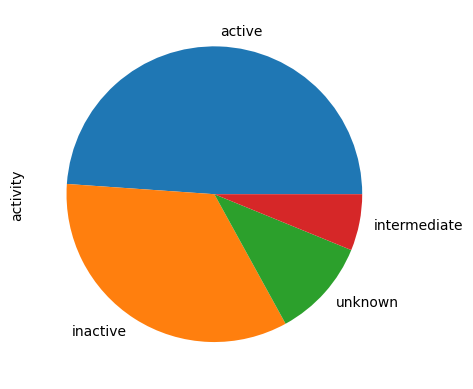

In [7]:
df.activity.value_counts().plot(kind='pie')

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [9]:
dataset = CustomDataset(df.smiles, df.activity)

In [10]:
from torch.utils.data import random_split

[0.8 *len(dataset)], [0.1 *len(dataset)], [0.1 *len(dataset)]

([4424.0], [553.0], [553.0])

In [11]:
train_dataset, test_dataset, val_dataset = random_split(dataset, [4424, 553, 553]) # 80, 10, 10
len(train_dataset + test_dataset + val_dataset)

5530

In [12]:
for smiles, labels in train_dataset:
    print("Input ID:\n " ,smiles)
    print("Label:\n" ,labels)
    break

Input ID:
  N#Cc1ccc2nc(N)n(-c3nc4c(s3)CCCC4)c2c1
Label:
 inactive


# Tokenization

In [13]:
## code borrowd from https://github.com/topazape/LSTM_Chem/blob/master/lstm_chem/utils/smiles_tokenizer2.py

class SmilesTokenizer(object):
    def __init__(self):
        atoms = [
            'Al', 'As', 'B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'K', 'Li', 'N',
            'Na', 'O', 'P', 'S', 'Se', 'Si', 'Te'
        ]
        special = [
            '(', ')', '[', ']', '=', '#', '%', '0', '1', '2', '3', '4', '5',
            '6', '7', '8', '9', '+', '-', 'se', 'te', 'c', 'n', 'o', 's'
        ]

        self.table = sorted(atoms, key=len, reverse=True) + special 

        self.table_2_chars = list(filter(lambda x: len(x) == 2, self.table))
        self.table_1_chars = list(filter(lambda x: len(x) == 1, self.table))
        self.vocab_dict = {}

    def tokenize(self, smiles):
        smiles = smiles + ' '
        N = len(smiles)
        token = []
        i = 0
        while (i < N):
            c1 = smiles[i]
            c2 = smiles[i:i + 2]

            if c2 in self.table_2_chars:
                token.append(c2)
                i += 2
                continue

            if c1 in self.table_1_chars:
                token.append(c1)
                i += 1
                continue

            i += 1

        return np.asarray(token, dtype=object)
        
    def vocaburaly(self):
        vocab_dict = {}
        for i, tok in enumerate(self.table):
            vocab_dict[tok] = i
        return vocab_dict
    
    def index_encode(self, tokenized_smiles):
        vocab_dict = {}
        for i, tok in enumerate(self.table):
            vocab_dict[tok] = i
        encoded = [vocab_dict[t] for t in tokenized_smiles ]
        return encoded

In [14]:
tokenizer = SmilesTokenizer()
tokens = [tokenizer.tokenize(x) for x in df.smiles]
vocabulary = tokenizer.vocaburaly()
indexed_smiles = [tokenizer.index_encode(x) for x in tokens]

# Generate the SMILES token vocabulary

In [15]:
vocabulary

{'Al': 0,
 'As': 1,
 'Br': 2,
 'Cl': 3,
 'Li': 4,
 'Na': 5,
 'Se': 6,
 'Si': 7,
 'Te': 8,
 'B': 9,
 'C': 10,
 'F': 11,
 'H': 12,
 'I': 13,
 'K': 14,
 'N': 15,
 'O': 16,
 'P': 17,
 'S': 18,
 '(': 19,
 ')': 20,
 '[': 21,
 ']': 22,
 '=': 23,
 '#': 24,
 '%': 25,
 '0': 26,
 '1': 27,
 '2': 28,
 '3': 29,
 '4': 30,
 '5': 31,
 '6': 32,
 '7': 33,
 '8': 34,
 '9': 35,
 '+': 36,
 '-': 37,
 'se': 38,
 'te': 39,
 'c': 40,
 'n': 41,
 'o': 42,
 's': 43}

In [16]:
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
vocab1 = vocab(ordered_dict)
vocab1.insert_token("<pad>", 0)
vocab1.insert_token("<unk>", 1)
vocab1.set_default_index(1)

In [17]:
ordered_dict

OrderedDict([('s', 43),
             ('o', 42),
             ('n', 41),
             ('c', 40),
             ('te', 39),
             ('se', 38),
             ('-', 37),
             ('+', 36),
             ('9', 35),
             ('8', 34),
             ('7', 33),
             ('6', 32),
             ('5', 31),
             ('4', 30),
             ('3', 29),
             ('2', 28),
             ('1', 27),
             ('0', 26),
             ('%', 25),
             ('#', 24),
             ('=', 23),
             (']', 22),
             ('[', 21),
             (')', 20),
             ('(', 19),
             ('S', 18),
             ('P', 17),
             ('O', 16),
             ('N', 15),
             ('K', 14),
             ('I', 13),
             ('H', 12),
             ('F', 11),
             ('C', 10),
             ('B', 9),
             ('Te', 8),
             ('Si', 7),
             ('Se', 6),
             ('Na', 5),
             ('Li', 4),
             ('Cl', 3),
             ('

In [18]:
sorted_by_freq_tuples[:7]

[('s', 43), ('o', 42), ('n', 41), ('c', 40), ('te', 39), ('se', 38), ('-', 37)]

In [19]:
vocab1.get_itos()[:10]

['<pad>', '<unk>', 's', 'o', 'n', 'c', 'te', 'se', '-', '+']

In [20]:
print(f"Vocabulary size: {len(vocab1)}")

Vocabulary size: 45


In [21]:
num_class = len(set([label for (text, label) in train_dataset]))
print(f"Number of classes: {num_class}")

Number of classes: 4


In [22]:
text_pipeline = lambda x: [vocab1[token] for token in tokenizer.tokenize(x)]
text_pipeline("O=S(=O)")

[29, 22, 27, 26, 22, 29, 25]

In [23]:
label_pipeline = lambda x: 0 if x == "active" else (1 if x == "inactive" else (2 if x == "unknown" else 3))
label_pipeline("unknown")

2

# SMILES to Tensor transformation

In [24]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for   _text, _label in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text),
                                      dtype=torch.long)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list,
                                 dtype=torch.long)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(text_list,
                                                     batch_first=True)  
    return padded_text_list, label_list, lengths

In [25]:
collate_batch(val_dataset)

(tensor([[35, 29,  5,  ...,  0,  0,  0],
         [35, 35, 26,  ...,  0,  0,  0],
         [35, 29,  5,  ...,  0,  0,  0],
         ...,
         [35, 29, 35,  ...,  0,  0,  0],
         [35, 35, 30,  ...,  0,  0,  0],
         [35, 29,  5,  ...,  0,  0,  0]]),
 tensor([1, 1, 2, 0, 3, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1,
         1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1,
         1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 0,
         0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1, 0, 0, 3, 1, 1, 2, 1, 0,
         1, 3, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 3, 0, 3, 1, 1, 0, 1, 1,
         2, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0, 0, 2, 1, 0, 2,
         1, 0, 1, 3, 1, 0, 1, 1, 0, 0, 0, 0, 3, 3, 1, 1, 0, 1, 2, 3, 1, 2, 0, 0,
         0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0,
         3, 1, 0, 1, 0, 0, 1, 2, 1, 0, 3, 2, 2, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1,
         

In [26]:
train_dataloader = DataLoader(train_dataset,batch_size=10, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset,batch_size=10, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True, collate_fn=collate_batch)

In [27]:
text_batch, label_batch, length_batch = next(iter(test_dataloader))
print(text_batch)
print(label_batch)
print(length_batch)
print(text_batch.shape)

tensor([[30, 35, 26, 22, 29, 25,  5, 18,  5,  5,  5,  5, 17,  4,  5,  4, 26,  8,
          5, 16,  5,  5,  5,  5,  5, 16, 25,  5, 18, 17,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30,  5, 18,  5, 26,  8,  5, 17,  4,  5, 16,  5,  5,  5, 24,  4, 33, 23,
          5,  8, 16,  4, 17, 25,  5, 26, 29, 25,  4,  5, 17,  5,  5,  5,  5,  5,
         18, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [35, 30, 18, 35, 35, 35, 26, 30, 35, 26, 22, 29, 25,  5, 17,  5,  4,  5,
         26, 30, 35,  5, 16,  5,  5, 26, 42, 25,  5,  5,  5, 16, 42, 25,  4,  5,
         17, 30, 35, 17, 35, 35, 35, 35, 17, 25, 35, 35, 18,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [35, 29,  5, 18,  5,  5, 26, 29, 35, 25, 

# Model

In [28]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size,
                 num_layers, fc_hidden_size, output_size):
        super(). __init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim (embedding))
        # batch_dim = number of samples per batch
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, num_layers,
                           batch_first=True, bidirectional=True) 
        # only use the hidden_size, since its a many to one
        self.fc1 = nn.Linear(rnn_hidden_size * num_layers, fc_hidden_size)  
        
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(fc_hidden_size, output_size) 
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        # text dim: [sentence length, batch size]
        # text_length = [batch size]
        
        # [sentence len, batch size] => [sentence len, batch size, embedding size]
        out = self.embedding(text)
        
        # pack sequence to avoid using <paddings> during computations (saves computations)
        # lengths needs to be on cpu
        out = nn.utils.rnn.pack_padded_sequence(out, text_lengths.to('cpu'),
                                                enforce_sorted=False, batch_first=True)
        # =>  [batch_size, sentence len,  embedding dim]
        
        # Propagate input through LSTM
        out, (hidden, cell) = self.rnn(out) ## lstm with input, hidden, and internal (cell) state
        # out dim: [batch size, sentence length, hidden dim]
        # cell dim: [num layers, batch size, hidden dim]
        # hidden dim: [num_layers, batch_size, hidden dim]
        
        # final layer foward hidden state     
        hidden_fwd = hidden[-2]
        # final layer backwaed hidden state 
        hidden_bck = hidden[-1]
        
        # concatenate the 2 layers to pass to linear layer
        # hidden_fwd/bck = [batch size, hid dim]
        out = torch.cat((hidden_fwd, hidden_bck), dim = 1)
        # out = [batch size, hid dim * 2]

        out = self.fc1(out) ## first dense layer
        out = self.relu(out)
        out = self.fc2(out) ## final layer
        out = self.sigmoid(out) 
        return out

In [29]:
vocab_size = len(vocab1) ## len of vocab size
embed_dim = 70 ## input size, usually around 50-500 dimensions
num_layers = 2 ## number of recurrent layers, 2 would mean stacking 2 layers to form stacked LSTM
rnn_hidden_size = 100 ## usually around 100-500 dimensions
fc_hidden_size = 100 ## usually around 100-500 dimensions
output_size = len(df.activity.unique()) ## num_classes 3

In [30]:
## Now we will instantiate the class LSTM1 object.

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size,
            num_layers, fc_hidden_size, output_size)

In [31]:
model

RNN(
  (embedding): Embedding(45, 70, padding_idx=0)
  (rnn): LSTM(70, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=4, bias=True)
  (sigmoid): Sigmoid()
)

# Train loop

In [32]:
def train(dataloader):
    # model training mode (gradient computation)
    model.train()
    # initailiz acc, and loss at zero 
    total_acc, total_loss = 0, 0
    for idx, (text, label, length) in enumerate (dataloader):
        # reset gradients to zero before each instance
        optimizer.zero_grad()
        # label predictions (forward papagation)
        # squeeze(1) => drop superficial one dimensional from a tensor
        predicted_label = model(text, length).squeeze(1) # or [:,0]
        # loss calculation
        loss = loss_fn(predicted_label, label)
        # compute gradients (backward propagation) 
        # to minimize loss functions with gradient descent
        loss.backward()
        # update parameters based on the computed gradients
        optimizer.step()
        # logging
        if not idx % 50:
            print(f"Epoch: {epoch + 1:04d}/{num_epochs:0d} | "
                  f"Batch {idx:03d}/{len(dataloader):03d} | "
                  f"Loss: {loss:.4f}")
        # compute total accuracy
        # return an indice of the max value of all elements
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        # compute total loss after back prop and parameter update
        total_loss += loss.item() * label.size(0)
    # compare true labels with the predicted labels to compute accuracy
    return total_acc/len(dataloader.dataset), \
            total_loss/len(dataloader.dataset)

In [33]:
def evaluate(dataloader):
    # model evaluation mode (no gradient computation)
    model.eval()
    # initailize acc, and loss at zero 
    total_acc, total_loss = 0, 0
    # disabling gradient calculation
    with torch.no_grad():
        for text, label, length in dataloader:
            # label predictions (forward papagation)
            # squeeze(1) => drop superficial one dimensional from a tensor
            predicted_label = model(text, length).squeeze(1) # reshape
            # loss calculation
            loss = loss_fn(predicted_label, label)
            # compute total accuracy
            # return an indice of the max value of all elements
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            # compute total loss after back prop and parameter update
            total_loss += loss.item() * label.size(0)
        # compare true labels with the predicted labels to compute accuracy
        return total_acc/len(dataloader.dataset), \
                total_loss/len(dataloader.dataset)

In [34]:
# for multiclass classification we use
loss_fn = nn.CrossEntropyLoss()
# Adam Optimizer to update parameters based on the computed gradients
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
model = model.to(device)
loss_fn = loss_fn.to(device)

In [36]:
torch.manual_seed(1)
num_epochs = 100

start_time = time.time()
train_loss_arr = []
validation_loss_arr = []
acc_train_arr = []
acc_val_arr = []

for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dataloader)
    acc_val , loss_val = evaluate(val_dataloader)
    train_loss_arr.append(loss_train)
    validation_loss_arr.append(loss_val)
    acc_train_arr.append(acc_train)
    acc_val_arr.append(acc_val)
    print(f"Train Acc.: {100 * acc_train:.2f}%"
          f"\nValid Acc.: {100 * acc_val:.2f}%")
    print(f'Time elapsed: {(time.time() - start_time) / 60:.2f} min')

Epoch: 0001/100 | Batch 000/443 | Loss: 1.3861
Epoch: 0001/100 | Batch 050/443 | Loss: 1.1031
Epoch: 0001/100 | Batch 100/443 | Loss: 1.3042
Epoch: 0001/100 | Batch 150/443 | Loss: 1.2999
Epoch: 0001/100 | Batch 200/443 | Loss: 1.3760
Epoch: 0001/100 | Batch 250/443 | Loss: 1.1379
Epoch: 0001/100 | Batch 300/443 | Loss: 1.2006
Epoch: 0001/100 | Batch 350/443 | Loss: 1.1060
Epoch: 0001/100 | Batch 400/443 | Loss: 1.4049
Train Acc.: 48.42%
Valid Acc.: 49.19%
Time elapsed: 1.54 min
Epoch: 0002/100 | Batch 000/443 | Loss: 1.2029
Epoch: 0002/100 | Batch 050/443 | Loss: 1.1029
Epoch: 0002/100 | Batch 100/443 | Loss: 1.4227
Epoch: 0002/100 | Batch 150/443 | Loss: 1.1054
Epoch: 0002/100 | Batch 200/443 | Loss: 1.1254
Epoch: 0002/100 | Batch 250/443 | Loss: 1.2146
Epoch: 0002/100 | Batch 300/443 | Loss: 1.2115
Epoch: 0002/100 | Batch 350/443 | Loss: 1.2354
Epoch: 0002/100 | Batch 400/443 | Loss: 1.0584
Train Acc.: 48.42%
Valid Acc.: 49.19%
Time elapsed: 2.87 min
Epoch: 0003/100 | Batch 000/443 

Epoch: 0018/100 | Batch 050/443 | Loss: 1.0226
Epoch: 0018/100 | Batch 100/443 | Loss: 1.0067
Epoch: 0018/100 | Batch 150/443 | Loss: 0.9248
Epoch: 0018/100 | Batch 200/443 | Loss: 0.7731
Epoch: 0018/100 | Batch 250/443 | Loss: 0.8715
Epoch: 0018/100 | Batch 300/443 | Loss: 0.9197
Epoch: 0018/100 | Batch 350/443 | Loss: 0.9152
Epoch: 0018/100 | Batch 400/443 | Loss: 1.2647
Train Acc.: 75.59%
Valid Acc.: 68.54%
Time elapsed: 23.47 min
Epoch: 0019/100 | Batch 000/443 | Loss: 1.0369
Epoch: 0019/100 | Batch 050/443 | Loss: 0.7972
Epoch: 0019/100 | Batch 100/443 | Loss: 0.7719
Epoch: 0019/100 | Batch 150/443 | Loss: 0.8342
Epoch: 0019/100 | Batch 200/443 | Loss: 0.9169
Epoch: 0019/100 | Batch 250/443 | Loss: 0.9436
Epoch: 0019/100 | Batch 300/443 | Loss: 0.8432
Epoch: 0019/100 | Batch 350/443 | Loss: 1.2742
Epoch: 0019/100 | Batch 400/443 | Loss: 0.7939
Train Acc.: 76.79%
Valid Acc.: 71.25%
Time elapsed: 24.54 min
Epoch: 0020/100 | Batch 000/443 | Loss: 0.9699
Epoch: 0020/100 | Batch 050/44

Epoch: 0035/100 | Batch 050/443 | Loss: 0.9442
Epoch: 0035/100 | Batch 100/443 | Loss: 0.8470
Epoch: 0035/100 | Batch 150/443 | Loss: 0.7468
Epoch: 0035/100 | Batch 200/443 | Loss: 1.0079
Epoch: 0035/100 | Batch 250/443 | Loss: 0.9737
Epoch: 0035/100 | Batch 300/443 | Loss: 0.8701
Epoch: 0035/100 | Batch 350/443 | Loss: 0.9568
Epoch: 0035/100 | Batch 400/443 | Loss: 0.9397
Train Acc.: 82.32%
Valid Acc.: 70.52%
Time elapsed: 43.14 min
Epoch: 0036/100 | Batch 000/443 | Loss: 0.8437
Epoch: 0036/100 | Batch 050/443 | Loss: 0.9410
Epoch: 0036/100 | Batch 100/443 | Loss: 0.8444
Epoch: 0036/100 | Batch 150/443 | Loss: 0.9365
Epoch: 0036/100 | Batch 200/443 | Loss: 0.8686
Epoch: 0036/100 | Batch 250/443 | Loss: 0.7439
Epoch: 0036/100 | Batch 300/443 | Loss: 0.7437
Epoch: 0036/100 | Batch 350/443 | Loss: 1.0567
Epoch: 0036/100 | Batch 400/443 | Loss: 0.9001
Train Acc.: 82.26%
Valid Acc.: 71.25%
Time elapsed: 44.22 min
Epoch: 0037/100 | Batch 000/443 | Loss: 1.0437
Epoch: 0037/100 | Batch 050/44

Epoch: 0052/100 | Batch 050/443 | Loss: 0.8596
Epoch: 0052/100 | Batch 100/443 | Loss: 0.8501
Epoch: 0052/100 | Batch 150/443 | Loss: 0.8493
Epoch: 0052/100 | Batch 200/443 | Loss: 0.9699
Epoch: 0052/100 | Batch 250/443 | Loss: 0.8702
Epoch: 0052/100 | Batch 300/443 | Loss: 0.7964
Epoch: 0052/100 | Batch 350/443 | Loss: 0.9685
Epoch: 0052/100 | Batch 400/443 | Loss: 0.9437
Train Acc.: 84.00%
Valid Acc.: 72.33%
Time elapsed: 61.57 min
Epoch: 0053/100 | Batch 000/443 | Loss: 0.7437
Epoch: 0053/100 | Batch 050/443 | Loss: 0.8437
Epoch: 0053/100 | Batch 100/443 | Loss: 0.8437
Epoch: 0053/100 | Batch 150/443 | Loss: 0.8756
Epoch: 0053/100 | Batch 200/443 | Loss: 0.7982
Epoch: 0053/100 | Batch 250/443 | Loss: 0.9473
Epoch: 0053/100 | Batch 300/443 | Loss: 0.7697
Epoch: 0053/100 | Batch 350/443 | Loss: 0.7437
Epoch: 0053/100 | Batch 400/443 | Loss: 0.9749
Train Acc.: 84.18%
Valid Acc.: 73.06%
Time elapsed: 62.56 min
Epoch: 0054/100 | Batch 000/443 | Loss: 0.8701
Epoch: 0054/100 | Batch 050/44

Epoch: 0069/100 | Batch 050/443 | Loss: 0.9466
Epoch: 0069/100 | Batch 100/443 | Loss: 0.7680
Epoch: 0069/100 | Batch 150/443 | Loss: 0.8684
Epoch: 0069/100 | Batch 200/443 | Loss: 0.7729
Epoch: 0069/100 | Batch 250/443 | Loss: 0.9816
Epoch: 0069/100 | Batch 300/443 | Loss: 0.8438
Epoch: 0069/100 | Batch 350/443 | Loss: 0.9440
Epoch: 0069/100 | Batch 400/443 | Loss: 1.0701
Train Acc.: 86.44%
Valid Acc.: 70.71%
Time elapsed: 77.93 min
Epoch: 0070/100 | Batch 000/443 | Loss: 0.8490
Epoch: 0070/100 | Batch 050/443 | Loss: 1.0439
Epoch: 0070/100 | Batch 100/443 | Loss: 0.8700
Epoch: 0070/100 | Batch 150/443 | Loss: 0.7445
Epoch: 0070/100 | Batch 200/443 | Loss: 0.9440
Epoch: 0070/100 | Batch 250/443 | Loss: 0.8437
Epoch: 0070/100 | Batch 300/443 | Loss: 0.7437
Epoch: 0070/100 | Batch 350/443 | Loss: 0.9147
Epoch: 0070/100 | Batch 400/443 | Loss: 0.7455
Train Acc.: 87.61%
Valid Acc.: 70.89%
Time elapsed: 78.89 min
Epoch: 0071/100 | Batch 000/443 | Loss: 0.9437
Epoch: 0071/100 | Batch 050/44

Epoch: 0086/100 | Batch 050/443 | Loss: 0.8821
Epoch: 0086/100 | Batch 100/443 | Loss: 0.8970
Epoch: 0086/100 | Batch 150/443 | Loss: 0.7437
Epoch: 0086/100 | Batch 200/443 | Loss: 0.8437
Epoch: 0086/100 | Batch 250/443 | Loss: 1.1686
Epoch: 0086/100 | Batch 300/443 | Loss: 0.8676
Epoch: 0086/100 | Batch 350/443 | Loss: 0.8538
Epoch: 0086/100 | Batch 400/443 | Loss: 0.7438
Train Acc.: 89.22%
Valid Acc.: 71.79%
Time elapsed: 100.14 min
Epoch: 0087/100 | Batch 000/443 | Loss: 0.7437
Epoch: 0087/100 | Batch 050/443 | Loss: 0.9447
Epoch: 0087/100 | Batch 100/443 | Loss: 0.9382
Epoch: 0087/100 | Batch 150/443 | Loss: 0.7437
Epoch: 0087/100 | Batch 200/443 | Loss: 0.8456
Epoch: 0087/100 | Batch 250/443 | Loss: 0.8686
Epoch: 0087/100 | Batch 300/443 | Loss: 0.7437
Epoch: 0087/100 | Batch 350/443 | Loss: 0.9456
Epoch: 0087/100 | Batch 400/443 | Loss: 0.8437
Train Acc.: 89.47%
Valid Acc.: 72.15%
Time elapsed: 101.22 min
Epoch: 0088/100 | Batch 000/443 | Loss: 0.7437
Epoch: 0088/100 | Batch 050/

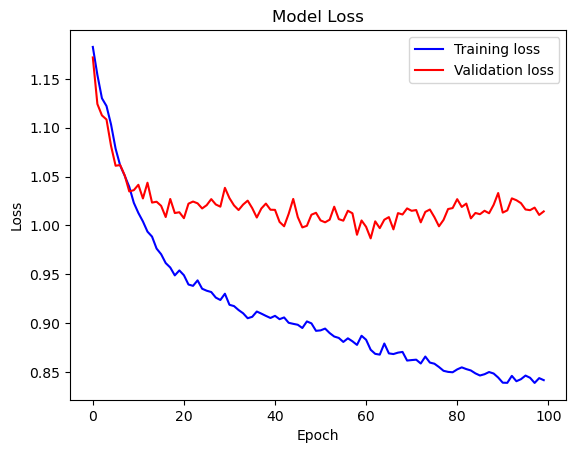

In [37]:
plt.plot(train_loss_arr,'b',label='Training loss')
plt.plot(validation_loss_arr,'r',label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.plot()
plt.show()

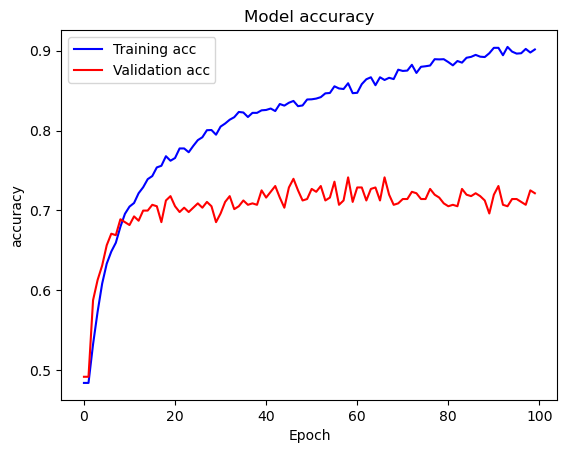

In [38]:
plt.plot(acc_train_arr,'b',label='Training acc')
plt.plot(acc_val_arr,'r',label='Validation acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.plot()
plt.show()

# Results

In [39]:
acc_test, _ = evaluate(test_dataloader)
print(f"Test Acc.: {100 * acc_test:.2f}%")

Test Acc.: 73.24%


In [40]:
## code inspired from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb
## code inspired from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2_lstm.ipynb

activity_label = {0: "active",
                   1: "inactive",
                   2: "unknown" ,
                   3: "intermediate"}

def predict(text, text_pipeline):
    # evaluation mode (no gradients)
    with torch.no_grad():
        # tokenize and index the tokens
        processed_text = torch.tensor(text_pipeline(text))
        # add a batch dimension
        processed_text = processed_text.unsqueeze(0).to(device)
        # compute sequence length
        text_length = processed_text.size(0)
        # convert to tensor and add a batch dimension
        text_length = torch.tensor(text_length).unsqueeze(0)
        # prediction
        prediction = model(processed_text, text_length)
        # reduction real numbers to values between 0 and 1
        probability = torch.softmax(prediction, dim=1)
        # get the max value of all elements
        predicted_probability, predicted_class, = torch.max(probability, dim=1)
        # convert tensor holding a single value into an integer
        return predicted_class.item(), predicted_probability.item()

In [41]:
df.smiles[3]

'COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2'

# Sanity check

#### Standardization of molecules

In [42]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs

In [43]:
def standardize(smiles):
    
    # create kdkit mol object
    mol = [Chem.MolFromSmiles(x) for x in smiles]
    # salt removal 
    largest_frag = [rdMolStandardize.LargestFragmentChooser().choose(x) for x in mol]
    # normalization to correct functional groups
    normal = [rdMolStandardize.Normalizer().normalize(x) for x in largest_frag]
    # uncharger
    uncharged = [rdMolStandardize.Uncharger().uncharge(x) for x in normal]
    # reionise
    reioned = [rdMolStandardize.Reionizer().reionize(x) for x in uncharged]
    # neutralize the mol
    neutral = [rdMolStandardize.Uncharger().uncharge(x) for x in reioned]
    # tautomer enumeration
    clean_mol = [rdMolStandardize.TautomerEnumerator().Canonicalize(x) for x in tqdm(neutral)]
    
    return clean_mol

In [44]:
block = BlockLogs()
mols = standardize(df['smiles'])
del block

  0%|          | 0/5530 [00:00<?, ?it/s]

In [45]:
df['mols'] = mols
print(f'Shape of the dataset: {df.shape}')
df.head()

Shape of the dataset: (5530, 5)


,inchikey,smiles,group,activity,mols
0,FNHKPVJBJVTLMP-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,train,active,<rdkit.Chem.rdchem.Mol object at 0x000002CAD0F...
1,CUDVHEFYRIWYQD-UHFFFAOYSA-N,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,train,active,<rdkit.Chem.rdchem.Mol object at 0x000002CAD0F...
2,TTZSNFLLYPYKIL-UHFFFAOYSA-N,Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...,test,active,<rdkit.Chem.rdchem.Mol object at 0x000002CAD0F...
3,UOVCGJXDGOGOCZ-UHFFFAOYSA-N,COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2,train,active,<rdkit.Chem.rdchem.Mol object at 0x000002CAD0F...
4,CUIHSIWYWATEQL-UHFFFAOYSA-N,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,active,<rdkit.Chem.rdchem.Mol object at 0x000002CAD0F...


In [46]:
df.smiles[3]

'COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2'

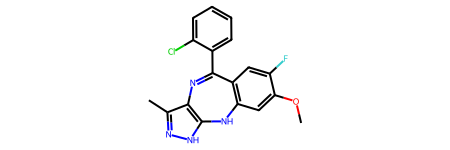

In [66]:
df['mols'][3]

In [67]:
text = "COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2"
pred_class, pred_proba = predict(text, text_pipeline)

print(f'Predicted Class: {pred_class} = {activity_label[pred_class]}')
print(f'Probability: {pred_proba}')

Predicted Class: 1 = inactive
Probability: 0.4753415882587433


In [68]:
df.smiles[495]

'C=CCOC(=O)c1c2c3ccc(SCCC)c4cccc(c-2nc1=O)c43'

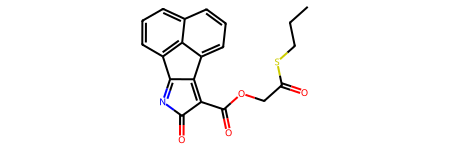

In [78]:
df['mols'][495]

In [80]:
text = "C=CCOC(=O)c1c2c3ccc(SCCC)c4cccc(c-2nc1=O)c43"
pred_class, pred_proba = predict(text, text_pipeline)

print(f'Predicted Class: {pred_class} = {activity_label[pred_class]}')
print(f'Probability: {pred_proba}')

Predicted Class: 1 = inactive
Probability: 0.4753415882587433


In [75]:
df.smiles[145]

'CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)nc(OC[C@@H](N)c3ccccc3)cc21'

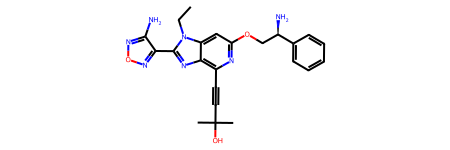

In [81]:
df['mols'][145]

In [82]:
text = "CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)nc(OC[C@@H](N)c3ccccc3)cc21"
pred_class, pred_proba = predict(text, text_pipeline)

print(f'Predicted Class: {pred_class} = {activity_label[pred_class]}')
print(f'Probability: {pred_proba}')

Predicted Class: 1 = inactive
Probability: 0.4753415882587433
